# Import thư viện

In [53]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os

# Đọc dữ liệu

In [2]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv',index_col='date')

# Chia tập validation

In [3]:
df_validate = df_train.iloc[-100:, :]
df_train = df_train.iloc[:-100, :]

In [4]:
df_test.shape

(190, 10)

In [5]:
df_train.shape

(630, 10)

In [6]:
df_validate.shape

(100, 10)

In [7]:
df_train.head()

,is_holiday,temperature,new_total_usage,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,
2022-01-01,True,21.89,1496.0,False,False,False,False,False,True,False
2022-01-02,False,21.96,1177.0,False,False,False,False,False,False,True
2022-01-03,True,21.99,1463.0,True,False,False,False,False,False,False
2022-01-04,False,22.57,4037.0,False,True,False,False,False,False,False
2022-01-05,False,22.97,4191.0,False,False,True,False,False,False,False


# Chuẩn bị dữ liệu để train

## Chuyển kiểu dữ liệu True/False thành 1/0

In [8]:
def convert_columns_to_int(df, weekday_cols_prefix='weekday_', holiday_col='is_holiday', num_weekdays=6):
    """
    Chuyển đổi các cột 'weekday' và 'is_holiday' của DataFrame sang kiểu dữ liệu int.

    Tham số:
    - df: DataFrame cần chuyển đổi.
    - weekday_cols_prefix: Tiền tố của các cột 'weekday'. Mặc định là 'weekday_'.
    - holiday_col: Tên cột ngày lễ cần chuyển đổi. Mặc định là 'is_holiday'.
    - num_weekdays: Số lượng cột 'weekday' cần chuyển đổi (mặc định là 6).
    
    Trả về:
    - DataFrame với các cột đã được chuyển sang kiểu int.
    """
    
    # Chuyển đổi các cột weekday_{i} thành int
    for i in range(0, num_weekdays + 1):  # Lặp từ 1 tới num_weekdays
        df[f'{weekday_cols_prefix}{i}'] = df[f'{weekday_cols_prefix}{i}'].astype(int)
    
    # Chuyển đổi cột is_holiday thành int
    df[holiday_col] = df[holiday_col].astype(int)
    
    return df

In [9]:
df_train = convert_columns_to_int(df=df_train)
df_validate = convert_columns_to_int(df=df_validate)
df_test = convert_columns_to_int(df=df_test)

## Scale dữ liệu số về 0-1

In [10]:
numerical_cols = ['temperature', 'new_total_usage']
scaler = MinMaxScaler()
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])
df_validate[numerical_cols] = scaler.transform(df_validate[numerical_cols])


In [11]:
df_test.head()

,is_holiday,temperature,new_total_usage,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,
2024-01-01,1,0.346911,0.100282,1,0,0,0,0,0,0
2024-01-02,0,0.332654,0.313559,0,1,0,0,0,0,0
2024-01-03,0,0.300747,0.498588,0,0,1,0,0,0,0
2024-01-04,0,0.272234,0.497175,0,0,0,1,0,0,0
2024-01-05,0,0.316361,0.498588,0,0,0,0,1,0,0


In [12]:
n_past = 30

# Tạo tập X, y

Giải thích: mỗi dòng dữ liệu ở tập X sẽ bao gồm n_past dòng dữ liệu ở quá khứ (bao gồm cả 8 features và 1 target value), tập y sẽ là target value ở dòng dữ liệu n_past+1

In [13]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset.iloc[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset.iloc[i,2])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_train,n_past=n_past)
testX,testY=createXY(df_test,n_past=n_past)
validX, validY = createXY(df_validate, n_past=n_past)

In [14]:
len(df_train)

630

In [15]:
len(df_test)

190

In [16]:
trainX.shape

(600, 30, 10)

In [17]:
n_cols = trainX.shape[2]

In [18]:
trainY.shape

(600,)

In [19]:
testX.shape

(160, 30, 10)

In [20]:
testY.shape

(160,)

In [21]:
trainX[0][0]

array([1.        , 0.25458248, 0.16384181, 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ])

In [22]:
df_train.iloc[0, :]

is_holiday         1.000000
temperature        0.254582
new_total_usage    0.163842
weekday_0          0.000000
weekday_1          0.000000
weekday_2          0.000000
weekday_3          0.000000
weekday_4          0.000000
weekday_5          1.000000
weekday_6          0.000000
Name: 2022-01-01, dtype: float64

In [23]:
trainX[0][29]

array([0.        , 0.2742702 , 0.12711864, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ])

In [24]:
df_train.iloc[29, :]

is_holiday         0.000000
temperature        0.274270
new_total_usage    0.127119
weekday_0          0.000000
weekday_1          0.000000
weekday_2          0.000000
weekday_3          0.000000
weekday_4          0.000000
weekday_5          0.000000
weekday_6          1.000000
Name: 2022-01-30, dtype: float64

In [25]:
trainY[0]

0.12853107344630849

In [26]:
df_train.iloc[30, :]

is_holiday         1.000000
temperature        0.213170
new_total_usage    0.128531
weekday_0          1.000000
weekday_1          0.000000
weekday_2          0.000000
weekday_3          0.000000
weekday_4          0.000000
weekday_5          0.000000
weekday_6          0.000000
Name: 2022-01-31, dtype: float64

# Train model

In [49]:
# # Define the build_model function
# def build_model(optimizer='adam'):
#     grid_model = Sequential()
#     grid_model.add(LSTM(90, return_sequences=True, input_shape=(n_past, n_cols)))
#     grid_model.add(LSTM(90))
#     grid_model.add(Dropout(0.2))
#     grid_model.add(Dense(1))
#     grid_model.compile(loss='mean_squared_error', optimizer=optimizer)
#     return grid_model


In [55]:
def build_model(optimizer='adam'):
    model = Sequential()
    
    # 1D CNN Layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_past, n_cols)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Stacked Bidirectional LSTM Layers
    model.add(Bidirectional(LSTM(100, return_sequences=True)))  # First Bi-LSTM layer
    model.add(Bidirectional(LSTM(100)))  # Second Bi-LSTM layer

    # Dense Output Layer
    model.add(Dense(1, activation='linear'))  # For regression tasks (predicted value)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [56]:
def calculate_mape(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    # Tránh chia cho 0
    non_zero_indices = y != 0
    y_non_zero = y[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    
    # Tính MAPE
    mape = np.mean(np.abs((y_non_zero - y_pred_non_zero) / y_non_zero)) * 100
    return mape

In [57]:
def plot_stock_prediction(y_pred, validY, scaler, numerical_cols, title='Predict Electricity Consumption'):
    """
    Hàm dự đoán và vẽ biểu đồ cho dữ liệu giá cổ phiếu dựa trên mô hình và scaler.

    Tham số:
    - y_pred: Dự đoán của mô hình, đầu vào cần được reshape
    - validY: Giá trị thực của dữ liệu kiểm tra, đầu vào cần được reshape
    - scaler: Bộ scaler đã được dùng để chuẩn hóa dữ liệu
    - numerical_cols: Số lượng cột dữ liệu (các thuộc tính số cần dự đoán)
    - title: Tiêu đề của biểu đồ (tùy chọn)
    """
    
    # Reshape y_pred và validY để chuẩn bị cho việc đảo ngược chuẩn hóa
    y_pred = y_pred.reshape(-1, 1)
    validY = validY.reshape(-1, 1)
    
    # Tạo các bản sao của y_pred và validY với số cột bằng số lượng thuộc tính số
    y_pred_copies_array = np.repeat(y_pred, len(numerical_cols), axis=-1)
    y_copies_array = np.repeat(validY, len(numerical_cols), axis=-1)
    
    # Inverse transform để đưa dữ liệu về giá trị ban đầu
    y_pred_before_scale = scaler.inverse_transform(y_pred_copies_array)[:, -1]
    y_before_scale = scaler.inverse_transform(y_copies_array)[:, -1]
    print(calculate_mape(y_pred=y_pred_before_scale, y=y_before_scale))
    
    
    # Vẽ biểu đồ
    plt.plot(y_before_scale, color='red', label='Real Electricity Consumption')
    plt.plot(y_pred_before_scale, color='blue', label='Predicted Electricity Consumption')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Electricity Consumption')
    plt.legend()
    plt.show()



In [58]:
model = build_model(optimizer='Adadelta')

c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the checkpoint callback to save only 5 most recent models
checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, 'model_epoch_{epoch:02d}_loss_{loss:.4f}.keras'), 
    monitor='loss',
    save_best_only=False,  # Save the model every epoch
    mode='auto',
    verbose=1,
    save_weights_only=False  # Save the entire model (architecture + weights)
)


In [60]:
def load_latest_checkpoint(directory):
    model_files = sorted(
        [f for f in os.listdir(directory) if f.endswith('.keras')],
        key=lambda x: os.path.getmtime(os.path.join(directory, x))
    )
    
    if model_files:
        latest_model = model_files[-1]
        print(f"Loading model: {latest_model}")
        return load_model(os.path.join(directory, latest_model))
    else:
        print("No model found, training from scratch.")
        return None

In [61]:
import re

In [62]:
def load_least_loss_model(directory):
    # Regular expression to extract loss from the filename
    loss_pattern = re.compile(r'_loss_([0-9]+\.[0-9]+)\.keras')

    # Find all model files and extract loss values
    model_files_with_loss = []
    for f in os.listdir(directory):
        if f.endswith('.keras'):
            match = loss_pattern.search(f)
            if match:
                loss_value = float(match.group(1))
                model_files_with_loss.append((f, loss_value))

    # If there are models available, sort by loss and return the one with the least loss
    if model_files_with_loss:
        model_files_with_loss.sort(key=lambda x: x[1])  # Sort by loss value (second item in tuple)
        least_loss_model = model_files_with_loss[0][0]  # Get the filename with the least loss
        print(f"Loading model with the least loss: {least_loss_model}")
        return load_model(os.path.join(directory, least_loss_model))
    else:
        print("No model found, training from scratch.")
        return None

In [63]:
model = load_least_loss_model(save_dir)
if model is None:
# Build a new model if no checkpoint is found
    model = build_model(optimizer='Adadelta')
# Train the model for a set number of epochs (e.g., 10)
history = model.fit(
    trainX, trainY, 
    batch_size=52, 
    epochs=1000, 
    verbose=1, 
    validation_data=(validX, validY),
    callbacks=[checkpoint]
)


Loading model with the least loss: model_epoch_932_loss_0.0502.keras
Epoch 1/1000
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0515
Epoch 1: saving model to saved_models\model_epoch_01_loss_0.0528.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0517 - val_loss: 0.0492
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0546
Epoch 2: saving model to saved_models\model_epoch_02_loss_0.0527.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0545 - val_loss: 0.0492
Epoch 3/1000
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0504
Epoch 3: saving model to saved_models\model_epoch_03_loss_0.0512.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0505 - val_loss: 0.0492
Epoch 4/1000
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0546
Epoch 4: saving model to saved_models\model_epoch_04_loss_0.0520.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0542 - val_loss: 0.0492
Epoch 5/1000
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0516
Epoch 5: sa

In [64]:
model_latest = load_least_loss_model(save_dir)

Loading model with the least loss: model_epoch_853_loss_0.0478.keras


In [65]:
y_pred_latest = model_latest.predict(validX)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001AFF92E4A40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


In [66]:
y_pred_latest

array([[0.496237  ],
       [0.5163231 ],
       [0.5184133 ],
       [0.49595007],
       [0.46923393],
       [0.44353396],
       [0.4375357 ],
       [0.4689798 ],
       [0.49060935],
       [0.4948485 ],
       [0.47377682],
       [0.44959867],
       [0.42557317],
       [0.42134318],
       [0.45486584],
       [0.47746468],
       [0.48318225],
       [0.46381786],
       [0.4397384 ],
       [0.41660246],
       [0.4129954 ],
       [0.44648615],
       [0.47018358],
       [0.47639447],
       [0.45683765],
       [0.4316412 ],
       [0.40743417],
       [0.399688  ],
       [0.42850414],
       [0.44767678],
       [0.4479612 ],
       [0.42369637],
       [0.39645174],
       [0.3680673 ],
       [0.35949668],
       [0.38986495],
       [0.40839204],
       [0.41031432],
       [0.38764042],
       [0.359834  ],
       [0.3342689 ],
       [0.32915965],
       [0.36257   ],
       [0.38551888],
       [0.3925166 ],
       [0.37507004],
       [0.3518167 ],
       [0.329

136.1332630092393


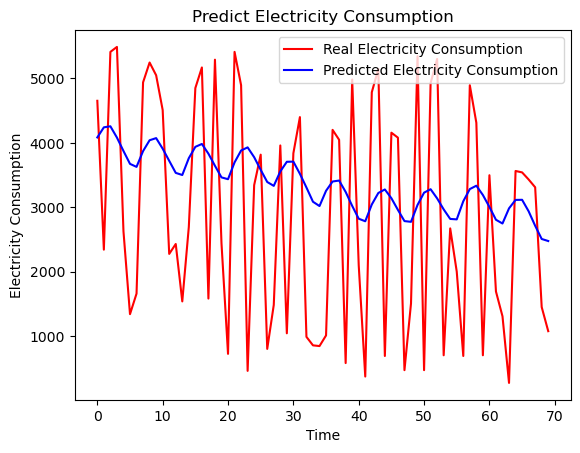

In [67]:
plot_stock_prediction(y_pred=y_pred_latest, validY=validY, scaler=scaler, numerical_cols=numerical_cols)

In [68]:
temp_pre = model_latest.predict(trainX)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


68.04720222660616


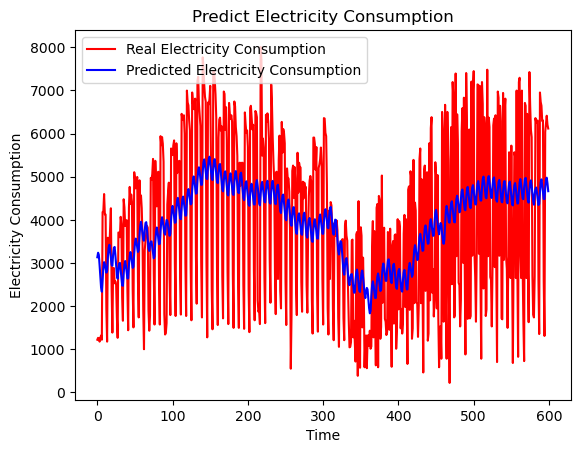

In [69]:
plot_stock_prediction(y_pred=temp_pre, validY=trainY, scaler=scaler, numerical_cols=numerical_cols)